#  Analytics Experience - Group Project - MSCI:6040 

By Group 2 (Chris Wagner, Palden Williams, Tarun Mandava  - Data Scientists) 
- September, 2020                                                             

Objective - This project is an exercise in using natural language processing to determine if social media posts meet a pre-specified criterion.  In this case, the test is to determine which social media posts truly reflect information tied to a natural disaster.  For this exercise, we are working with a test dataset of Twitter posts that have been manually reviewed from Kraggle.

Data source:  Real or Not?  NLP with Disaster Tweets dataset from Kaggle

In [2]:
# Dependencies and the libraries to import

import pandas as pd
import matplotlib.pyplot as mplt
import seaborn as sn
import matplotlib.pyplot as plt                     
import numpy as np           
import plotly.offline as plyo
#import cufflinks as cf
#plyo.init_notebook_mode()



In [3]:
#  Further library imports

import random
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
import unicodedata
from collections import defaultdict
import string

from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from tqdm import tqdm
stopwords = stopwords.words('english')
sn.set_context('notebook')

In [4]:
# Importing Kaggler data set

sample_submission_data = pd.read_csv("Data/OriginalData/sample_submission.csv")
test_data = pd.read_csv("Data/OriginalData/test.csv")
train_data = pd.read_csv("Data/OriginalData/train.csv")


In [5]:
sample_submission_data.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [6]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Word visualizations

#### Wordcloud logic

In [8]:
#Code sourced from : https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc

#import the wordcloud package
from wordcloud import WordCloud, STOPWORDS

#Define the word cloud function with a max of 200 words
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    #define additional stop words that are not contained in the dictionary
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)
    #Generate the word cloud
    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    #set the plot parameters
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout() 

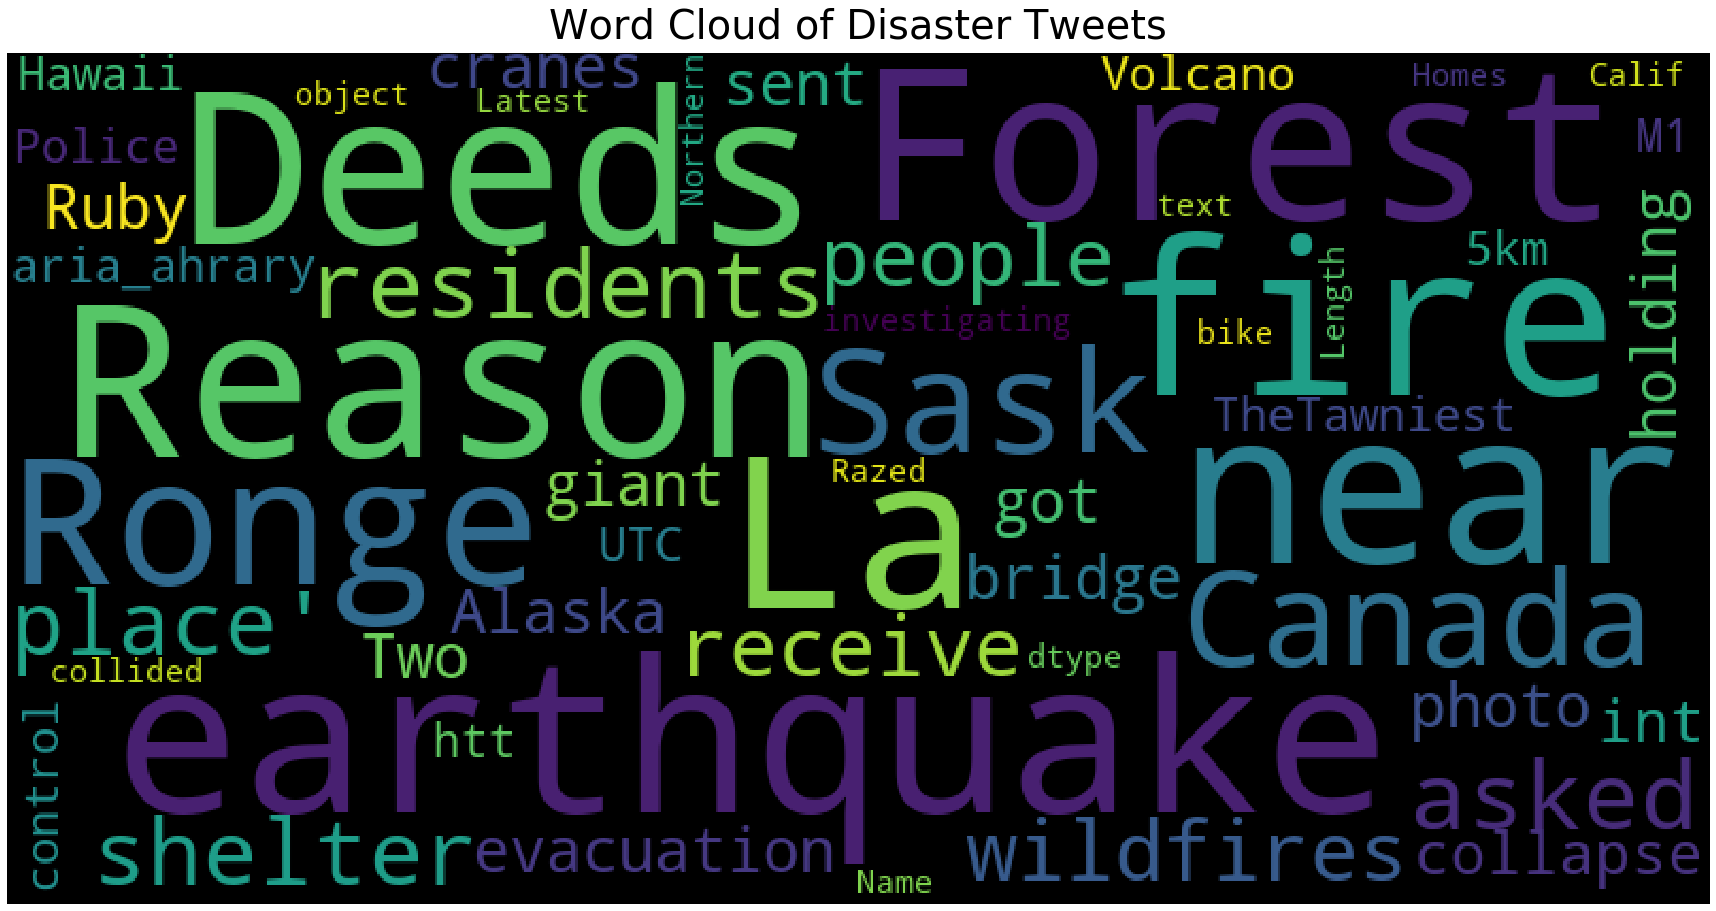

In [9]:
#Select disaster tweets from training dataset
disaster = train_data.loc[train_data['target'] == 1]
#run the function on the insincere questions
plot_wordcloud(disaster["text"], title="Word Cloud of Disaster Tweets")

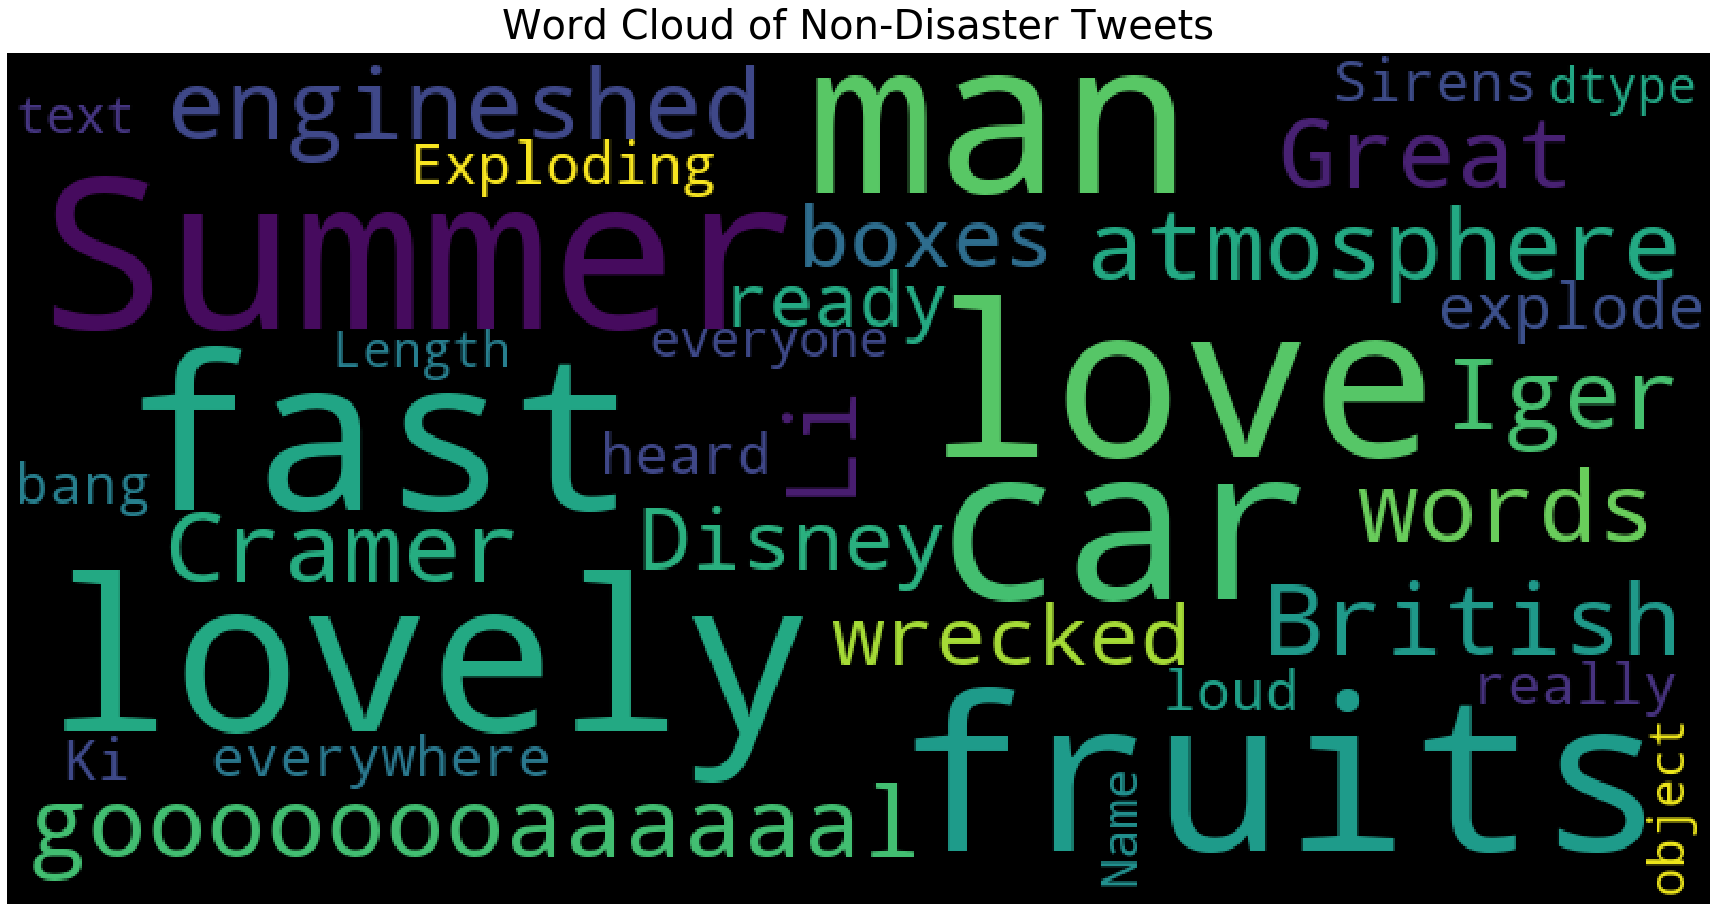

In [10]:
#Select disaster tweets from training dataset
nondisaster = train_data.loc[train_data['target'] == 0]
#run the function on the insincere questions
plot_wordcloud(nondisaster["text"], title="Word Cloud of Non-Disaster Tweets")

In [24]:
import re
def  clean_text(df, text):
    df[text] = df[text].str.lower()
    df[text] = df[text].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df
test_clean = clean_text(test_data, "text")
train_clean = clean_text(train_data, "text")


In [25]:
test_clean.head()

,id,keyword,location,text
0,0,NaN,NaN,just happened a terrible car crash
1,2,NaN,NaN,heard about earthquake is different cities sta...
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan


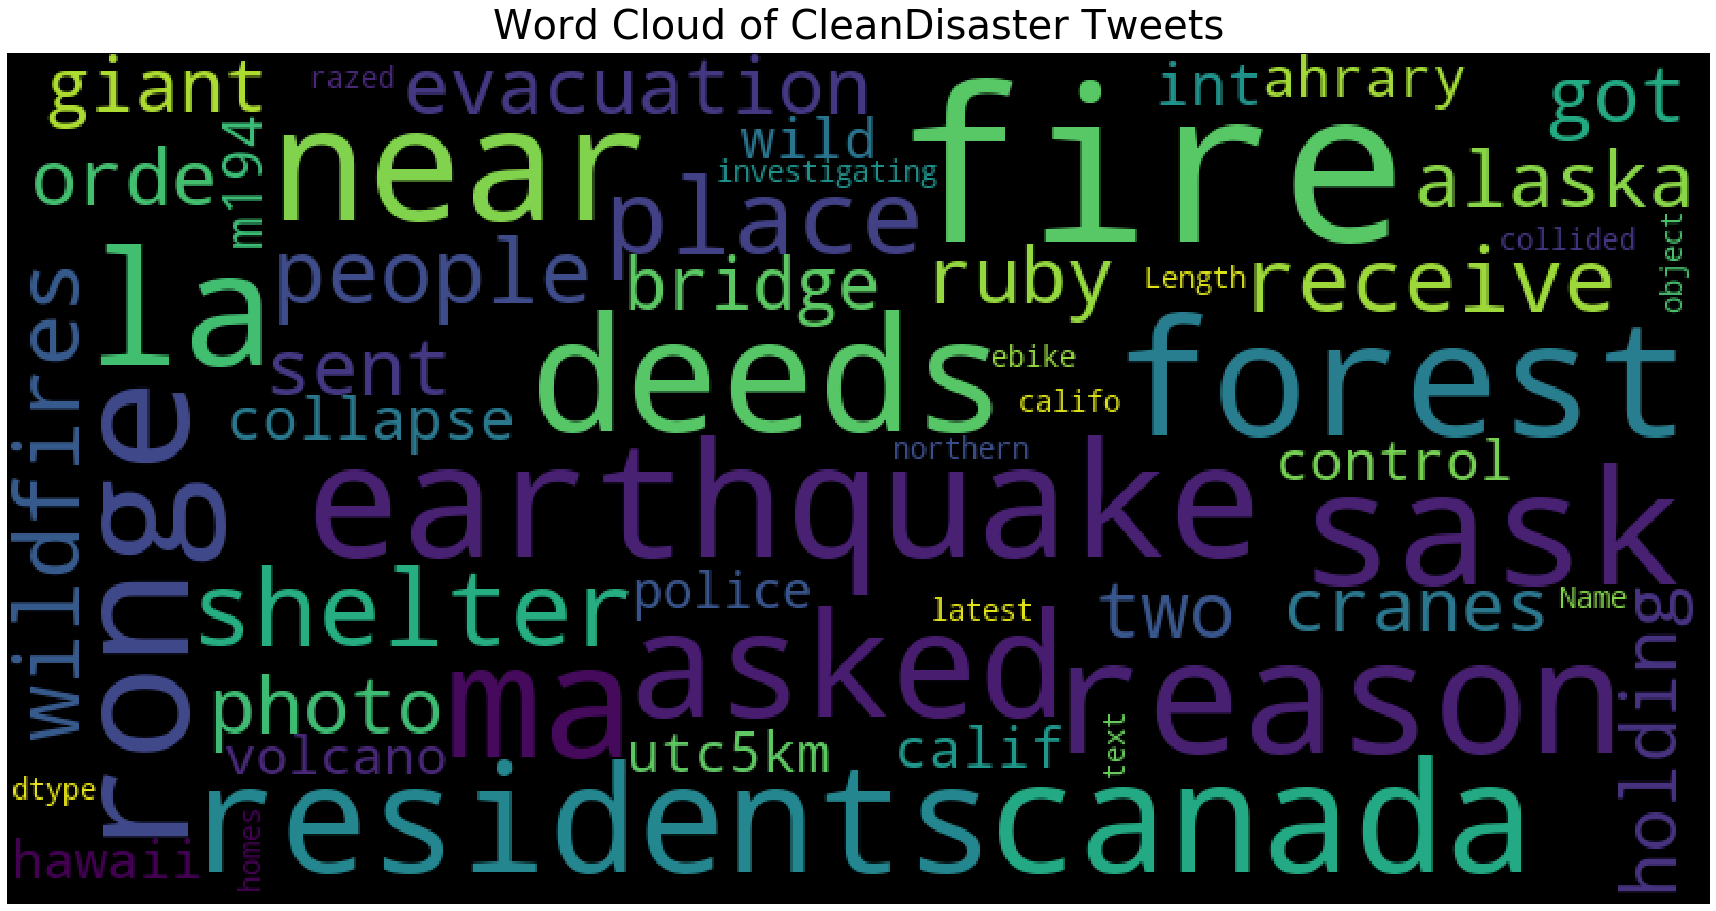

In [26]:
#Select disaster tweets from training dataset
cleandisaster = train_clean.loc[train_clean['target'] == 1]
#run the function on the insincere questions
plot_wordcloud(cleandisaster["text"], title="Word Cloud of CleanDisaster Tweets")

In [27]:
def ngram_extractor(text, n_gram):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

# Function to generate a dataframe with n_gram and top max_row frequencies
def generate_ngrams(df, col, n_gram, max_row):
    temp_dict = defaultdict(int)
    for question in df[col]:
        for word in ngram_extractor(question, n_gram):
            temp_dict[word] += 1
    temp_df = pd.DataFrame(sorted(temp_dict.items(), key=lambda x: x[1])[::-1]).head(max_row)
    temp_df.columns = ["word", "wordcount"] 
    return temp_df 

#Function to construct side by side comparison plots
def comparison_plot(df_1,df_2,col_1,col_2, space):
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    
    sns.barplot(x=col_2, y=col_1, data=df_1, ax=ax[0], color="royalblue")
    sns.barplot(x=col_2, y=col_1, data=df_2, ax=ax[1], color="royalblue")

    ax[0].set_xlabel('Word count', size=14)
    ax[0].set_ylabel('Words', size=14)
    ax[0].set_title('Top words in non-disaster tweets', size=18)

    ax[1].set_xlabel('Word count', size=14)
    ax[1].set_ylabel('Words', size=14)
    ax[1].set_title('Top words in disaster tweets', size=18)

    fig.subplots_adjust(wspace=space)
    
    plt.show()

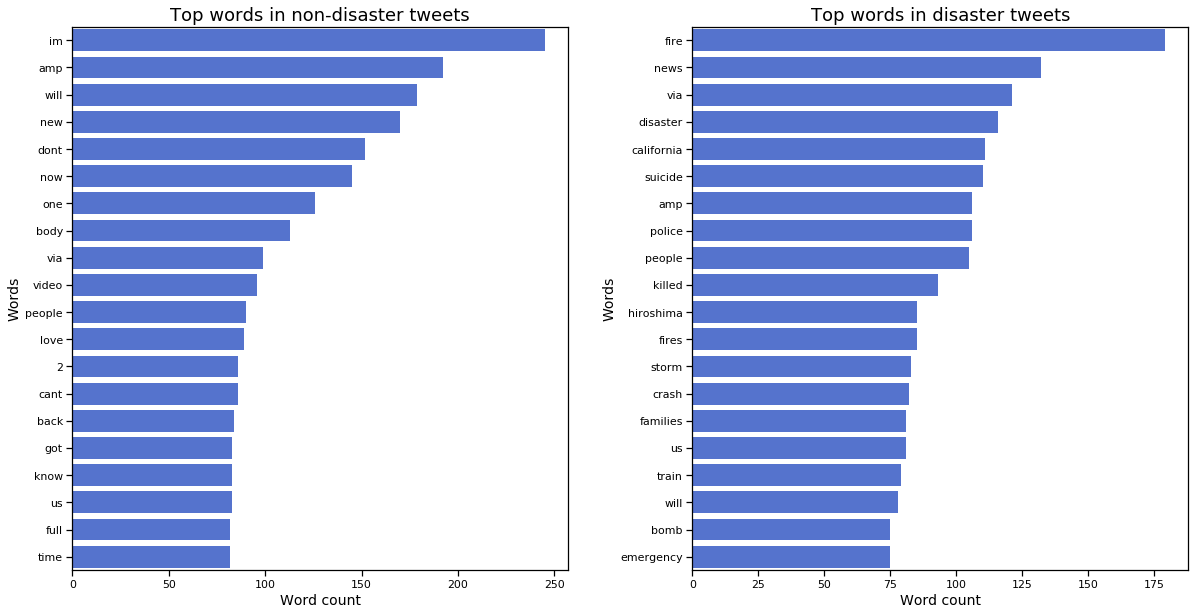

In [28]:
import seaborn as sns
sincere_1gram = generate_ngrams(train_data[train_data["target"]==0], 'text', 1, 20)
insincere_1gram = generate_ngrams(train_data[train_data["target"]==1], 'text', 1, 20)
#compare the bar plots
comparison_plot(sincere_1gram,insincere_1gram,'word','wordcount', 0.25)

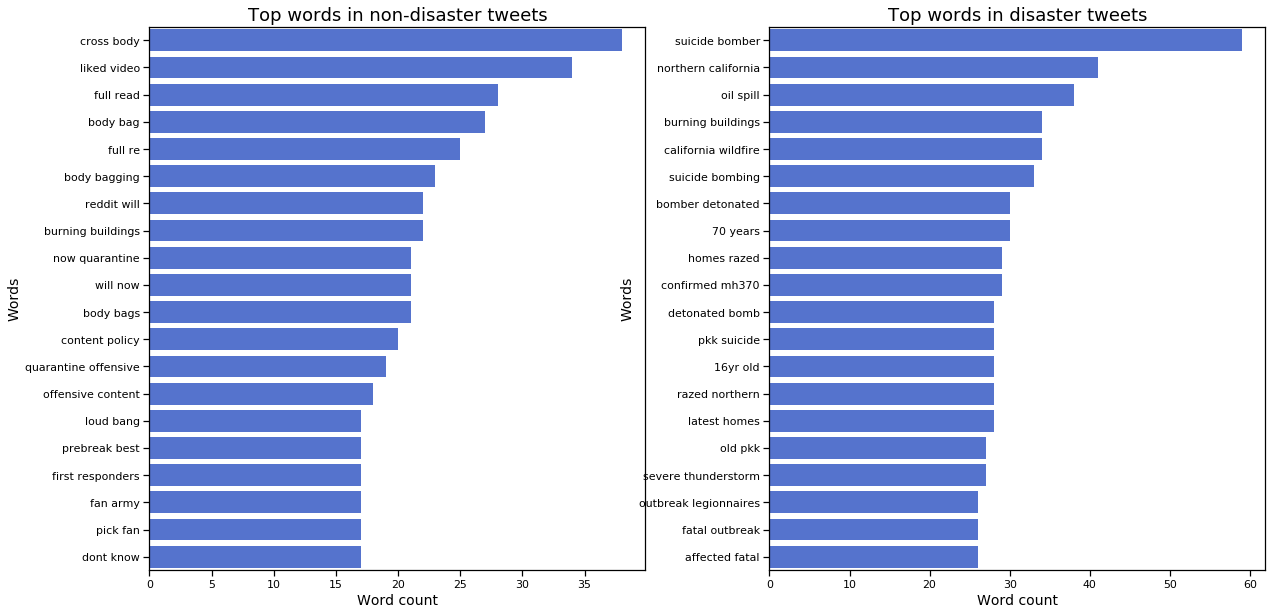

In [29]:
#Obtain sincere and insincere ngram based on 2 gram (top 20)
sincere_2gram = generate_ngrams(train_data[train_data["target"]==0], 'text', 2, 20)
insincere_2gram = generate_ngrams(train_data[train_data["target"]==1], 'text', 2, 20)
#compare the bar plots
comparison_plot(sincere_2gram,insincere_2gram,'word','wordcount', 0.25)

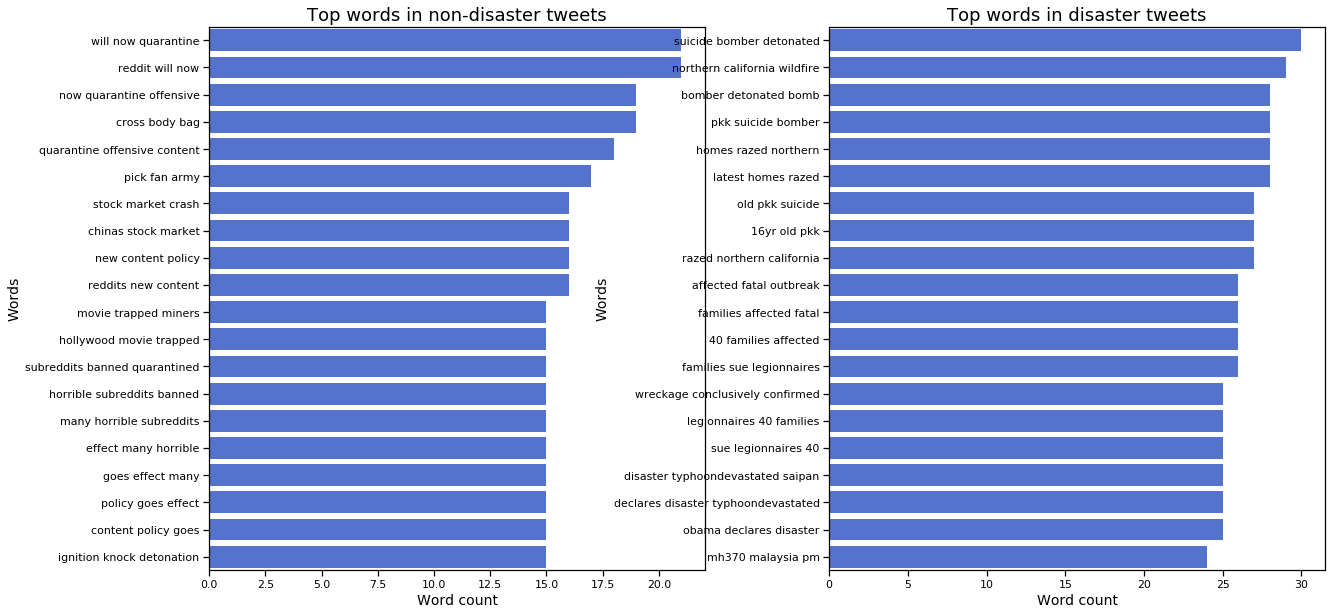

In [30]:
#Obtain sincere and insincere ngram based on 3 gram (top 20)
sincere_3gram = generate_ngrams(train_data[train_data["target"]==0], 'text', 3, 20)
insincere_3gram = generate_ngrams(train_data[train_data["target"]==1], 'text', 3, 20)
#compare the bar plots
comparison_plot(sincere_3gram,insincere_3gram,'word','wordcount', 0.25)

# Locations 

In [67]:
#Check number of unique keywords and locations
print (train_data.location.nunique(), test_data.location.nunique())

3341 1602


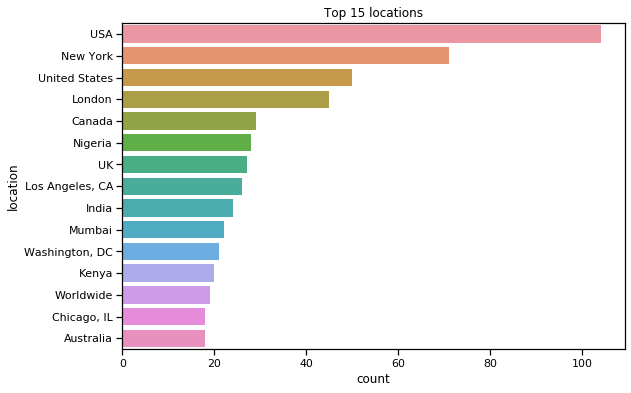

In [68]:
# Most common locations
plt.figure(figsize=(9,6))
sns.countplot(y=train_data.location, order = train_data.location.value_counts().iloc[:15].index)
plt.title('Top 15 locations')
plt.show()

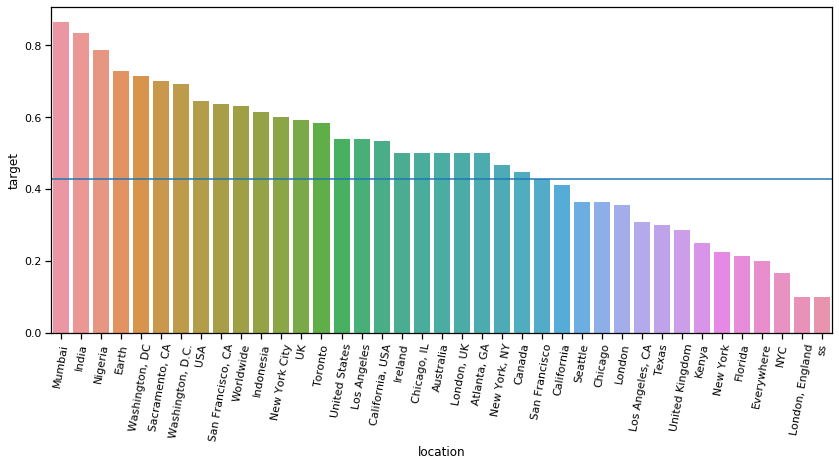

In [69]:
raw_loc = train_data.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = train_data[train_data.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)
plt.axhline(np.mean(train_data.target))
plt.xticks(rotation=80)
plt.show()

### Attempt at importing a cleanup function for scrubbing the data

Guys - one thing to note.  The spacy library gave me fits when I tried to use it.  I had to do the following to make sure I had the correct version of spacy as well as the en_core_web_sm library:
<ul>
    <li>pip install spacy --upgrade</li>
    <li>python -m spacy download en_core_web_sm </li>
</ul>

##### we'll use a common clean function to remove stop words, punctuation, and force words to lower case.  First stab is using the spacy library

In [64]:
nlp = spacy.load('en_core_web_sm')
# Clean text before feeding it to model
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, puncuation and reducing all characters to lowercase 
def cleanup_text(docs, logging=False):
    texts = []
    for doc in tqdm(docs):
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        #remove stopwords and punctuations 
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

SyntaxError: invalid syntax (<ipython-input-64-28a852cd9fff>, line 1)

In [32]:
# Cleanup text and make sure it retains original shape 
print('Original training data shape: ', train_clean['text'].shape)
train_cleaned = cleanup_text(train_clean['text'], logging=True)
print('Cleaned up training data shape: ', train_cleaned.shape)

Original training data shape:  (7613,)


NameError: name 'cleanup_text' is not defined

##### now that we have it tokenized, lets create a new column in the test and train sets to hold the tokens.

In [33]:
train_clean['token'] = cleanup_text(train_clean['text'],logging=False)
test_clean['token'] = cleanup_text(test_clean['text'],logging=False)

NameError: name 'cleanup_text' is not defined

In [ ]:
train_clean.head()

In [ ]:
# leaving lines to do further data cleanup exercises

In [ ]:
# Removing URL's

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

test_data['text'] = test_data['text'].apply(lambda x : remove_URL(x))

In [ ]:
# Removing HTML tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

test_data['text'] = test_data['text'].apply(lambda x : remove_html(x))

In [ ]:
# Remove punctuation's
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

test_data['text'] = test_data['text'].apply(lambda x : remove_punct(x))

In [ ]:
# function for Spelling Correction

from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

test_data['text'] = test_data['text'].apply(lambda x : correct_spellings(x))


### Vectorization

##### First off, the down and dirty vectorization using the scikit learn count vectorizer

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

In [36]:
count_vectorizer = CountVectorizer()

## let's get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(train_clean["token"][0:5])

KeyError: 'token'

In [37]:
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

#we have tokens... Yay!

NameError: name 'example_train_vectors' is not defined

In [ ]:
#now lets get the real things...
train_vectors = count_vectorizer.fit_transform(train_clean["token"])
test_vectors = count_vectorizer.transform(test_clean["token"])

In [ ]:
print(train_vectors[0].todense().shape)
print(train_vectors[0].todense())

######  There a litterally thousands of different ways to slice and dice the data into vectors.  Since we're being graded on the learning process, lets use that as one of the items for us to get familiar with as part of this project.  We'll add those below.

In [44]:
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

### Modeling

#### Putting a basic model here for us to play with as we get further along.

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeClassifier
from sklearn import model_selection


In [20]:
clf = RidgeClassifier()

In [21]:
scores = model_selection.cross_val_score(clf, train_vectors, train_clean["target"], cv=5, scoring="f1")
scores

NameError: name 'train_vectors' is not defined

In [42]:
#not the best scores....  Let's see if we do a different model instead...


In [ ]:
#I want to see if this might be a way to go for our vectorizer...
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

#### Creating a function that cross validates and picks the best model based on score

In [47]:
x = train_clean["tokens"]
y = train_clean["target"]

In [49]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split = train_test_split(x,y, test_size=0.2, random_state=0)
print(x_train.shape)
print(x_test.shape)

(6090,)
(1523,)


In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
def dummy(doc):
    return doc

tfidf = TfidfVectorizer(
         tokenizer=dummy,
         preprocessor=dummy,
         min_df = 0.000167

)

x_train = tfidf.fit_transform(x_train)

x_test =  tfidf.transform(x_test)

In [ ]:
#pip install xgboost
#pip install scikit-optimize
import xgboost as xgb
from sklearn.ensemble import forest 
from sklearn import tree
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import cross_val_score
import statistics as stats
from sklearn.feature_extraction.text import TfidfVectorizer
from skopt import BayesSearchCV

xg = xgb.XGBClassifier()
fo =  forest.RandomForestClassifier()
tr = tree.DecisionTreeClassifier()
lo = linear_model.LogisticRegression()
sv = svm.SVC()

xgb_score = cross_val_score(xg,x_train,y_train,cv=5)
ran_score = cross_val_score(fo,x_train,y_train,cv=5)
dtree_score = cross_val_score(tr,x_train,y_train,cv=5)
log_score = cross_val_score(lo,x_train,y_train,cv=5)
svm_score = cross_val_score(sv,x_train,y_train,cv=5)

# This Dataframe outputs the average score for each algorithms
df_score = pd.DataFrame({"model":["xgboost","RandomForestClassifier","DecisionTreeClassifier","LogisticRegression","Support vector machine"],"score":[stats.mean(xgb_score),stats.mean(ran_score),stats.mean(dtree_score),stats.mean(log_score),stats.mean(svm_score)]})
df_score
# We can see that Logistic Regression gave the best score

C:\Users\willi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\willi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\willi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\willi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\willi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\willi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solve